<a href="https://colab.research.google.com/github/kunalgaurav18/CE888/blob/main/Assignment1/CE888_Fire_NoFire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copying data to workspace

In [ ]:
!unzip /content/drive/MyDrive/Training.zip -d ./
!unzip /content/drive/MyDrive/Test.zip -d ./
# !rm -r ./logs/fit/*
# !rm -r ./models/*
# !zip -r ./logs.zip ./logs/fit/
# !cp -a ./logs /content/drive/MyDrive/Baseline_Model/logs/
# !cp -a -u ./models/ /content/drive/MyDrive/Baseline_Model/models/

In [ ]:
!pip install -q basic_image_eda

# Importing necessary libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from basic_image_eda import BasicImageEDA
import tensorflow as tf
from tensorflow.keras.models import Sequential,save_model
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D,Dropout,Flatten,BatchNormalization,AvgPool2D,GlobalAvgPool2D,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import datetime

# Train and Test directory

In [ ]:
train_path = './Training'
test_path = './Test'

In [ ]:
# fire_example = os.listdir(train_path+'/Fire/')[0]
# nofire_example = os.listdir(train_path+'/No_Fire/')[0]

# Performing basic EDA on the image dataset
Image shape and Batch size declaration

In [ ]:
img_shape = (254,254,3)
batch = 32

In [ ]:
# fire_img = plt.imread(train_path+'/Fire/'+fire_example)
# nofire_img = plt.imread(train_path+'/No_Fire/'+nofire_example)


found 39375 images.


  0%|          | 0/39375 [00:00<?, ?it/s]

Using 2 threads. (max:2)



100%|██████████| 39375/39375 [04:03<00:00, 161.81it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  39375

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpg']

min height                               |  254
max height                               |  254
mean height                              |  254.0
median height                            |  254

min width                                |  254
max width                                |  254
mean width                               |  254.0
median width                             |  254

mean height/width ratio                  |  1.0
median height/width ratio                |  1.0
recommended input size(by mean)          |  [256 256] (h x w, multiples of 8)
recommended input size(by mean)          |  [256 256] (h x w, multiples of 16)
recommended input size(by mean)          |  [256 256] (h x w, mul

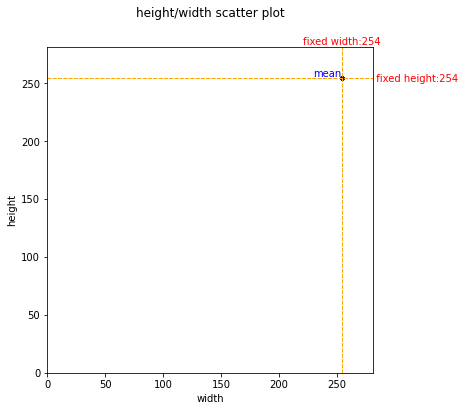

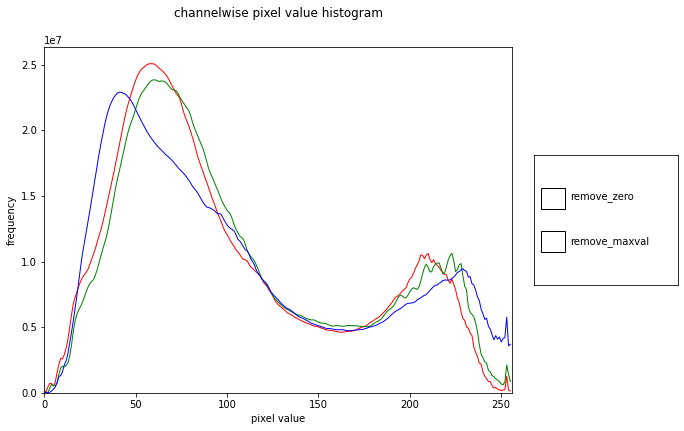

{'channels': [3],
 'dtype': 'uint8',
 'extensions': ['jpg'],
 'max_h': 254,
 'max_w': 254,
 'mean': array([0.3983561, 0.4169002, 0.4140679], dtype=float32),
 'mean_h': 254.0,
 'mean_hw_ratio': 1.0,
 'mean_w': 254.0,
 'median_h': 254,
 'median_hw_ratio': 1.0,
 'median_w': 254,
 'min_h': 254,
 'min_w': 254,
 'rec_hw_size_16': array([256, 256]),
 'rec_hw_size_32': array([256, 256]),
 'rec_hw_size_8': array([256, 256]),
 'std': array([0.24220918, 0.24493067, 0.26481178], dtype=float32)}

In [ ]:
BasicImageEDA.explore(train_path, dimension_plot = True, channel_hist = True,)

## Loading Data

Loading image dataset with the help of ImageDataGenerator class available in keras preprocessing package.

With the help of ImageDataGenerator we also perform some data augmentation which helps in learning the model correctly and also helps in reducing overfitting our model on training data.

Splitting of data into training set and validation set is performed in this step. 80% of the total training image will be used for training and 20% will be used for testing.

In [ ]:
train_image_gen = ImageDataGenerator(rescale=1.0/255, 
                                     brightness_range=(0.8, 1.5), 
                                     width_shift_range=0.1, 
                                     height_shift_range=0.1,
                                     horizontal_flip=True,
                                     vertical_flip=True, zoom_range=0.1,
                                     validation_split=0.2)

In [ ]:
test_image_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_image_gen.flow_from_directory(train_path, 
                                                      target_size=img_shape[:2],
                                                      color_mode='rgb',
                                                      class_mode='binary',
                                                      batch_size=batch,
                                                      shuffle=True,
                                                      subset='training')

Found 31501 images belonging to 2 classes.


In [ ]:
validation_generator = train_image_gen.flow_from_directory(train_path, 
                                                      target_size=img_shape[:2],
                                                      color_mode='rgb',
                                                      class_mode='binary',
                                                      batch_size=batch,
                                                      shuffle=True,
                                                      subset='validation')

Found 7874 images belonging to 2 classes.


In [ ]:
test_generator = test_image_gen.flow_from_directory(test_path, 
                                                    target_size=img_shape[:2], 
                                                    color_mode='rgb', 
                                                    class_mode='binary',
                                                    shuffle=False,
                                                    batch_size=batch)

Found 8617 images belonging to 2 classes.


## Visualizing sample images

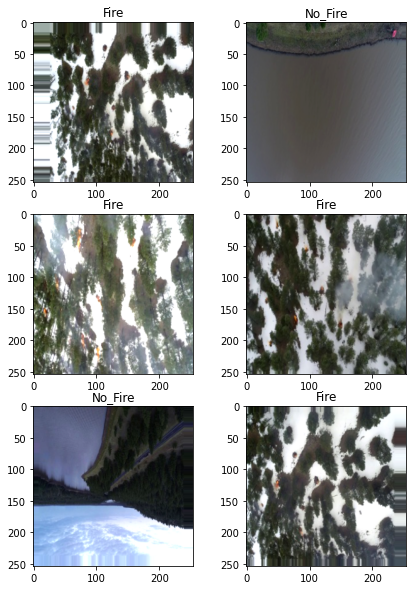

In [ ]:
imgs,cls = next(train_generator)

plt.figure(figsize=(7,10))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.imshow(imgs[i])
    plt.title('Fire' if cls[i]==0 else 'No_Fire')

## Looking at class disctibutions in training, validation and test set

Fire: 20015, No_fire: 11486


<BarContainer object of 2 artists>

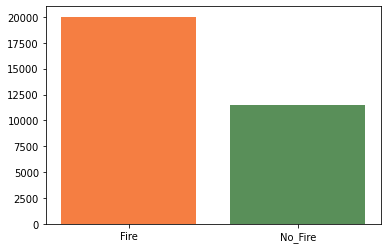

In [ ]:
_, count = np.unique(train_generator.classes, return_counts=True)
print('Fire: {}, No_fire: {}'.format(count[0],count[1]))
plt.bar(['Fire','No_Fire'],count, color=['#f57e42', '#598f59'])

Fire: 5003, No_fire: 2871


<BarContainer object of 2 artists>

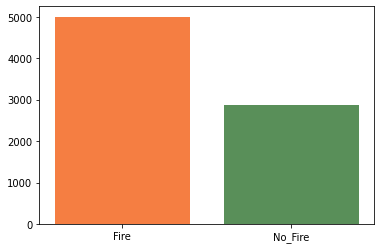

In [ ]:
_, count = np.unique(validation_generator.classes, return_counts=True)
print('Fire: {}, No_fire: {}'.format(count[0],count[1]))
plt.bar(['Fire','No_Fire'],count, color=['#f57e42', '#598f59'])

Fire: 5137, No_fire: 3480


<BarContainer object of 2 artists>

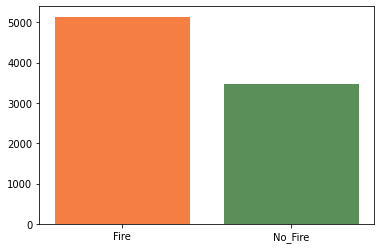

In [ ]:
_, count = np.unique(test_generator.classes, return_counts=True)
print('Fire: {}, No_fire: {}'.format(count[0],count[1]))
plt.bar(['Fire','No_Fire'],count, color=['#f57e42', '#598f59'])

## Baseline Model

In [ ]:
model = Sequential()

model.add(Conv2D(16, (5,5),padding='same',input_shape=img_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3,3),activation='relu'))
model.add(AvgPool2D())
model.add(Conv2D(64, (3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3),activation='relu'))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

### Model Compilation and Summary

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 254, 254, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 252, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 252, 252, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 64)      1

### Model Training

traingin the model with appropriate callbacks and checkpoints

In [ ]:
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stop = EarlyStopping(patience=10,verbose=1,monitor='val_accuracy',mode='max')
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1,write_graph=True,update_freq='batch',
                         write_images=True,profile_batch=[10,50])

checkpoint = ModelCheckpoint('models/{epoch:02d}_{val_accuracy:.04f}.h5', 
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=False,
                             mode='max')

model.fit(train_generator, epochs=200, verbose=1,callbacks=[early_stop,tensorboard,checkpoint], 
          validation_data=validation_generator)

Epoch 1/200
985/985 [==============================] - 697s 703ms/step - loss: 0.2702 - accuracy: 0.8982 - val_loss: 0.1133 - val_accuracy: 0.9675

Epoch 00001: saving model to models/01_0.9675.h5
Epoch 2/200
985/985 [==============================] - 690s 700ms/step - loss: 0.1487 - accuracy: 0.9511 - val_loss: 0.0844 - val_accuracy: 0.9655

Epoch 00002: saving model to models/02_0.9655.h5
Epoch 3/200
985/985 [==============================] - 693s 704ms/step - loss: 0.1145 - accuracy: 0.9612 - val_loss: 0.2126 - val_accuracy: 0.9493

Epoch 00003: saving model to models/03_0.9493.h5
Epoch 4/200
985/985 [==============================] - 692s 703ms/step - loss: 0.0978 - accuracy: 0.9671 - val_loss: 0.2493 - val_accuracy: 0.9012

Epoch 00004: saving model to models/04_0.9012.h5
Epoch 5/200
985/985 [==============================] - 691s 701ms/step - loss: 0.0845 - accuracy: 0.9718 - val_loss: 0.2421 - val_accuracy: 0.9060

Epoch 00005: saving model to models/05_0.9060.h5
Epoch 6/200
985

### Model Evaluation

In [ ]:
model.evaluate(test_generator)

270/270 [==============================] - 32s 108ms/step - loss: 1.0910 - accuracy: 0.6985


[1.0910167694091797, 0.6985029578208923]

### Loading and Evaluating intermediate models

In [ ]:
m = tf.keras.models.load_model('./models/13_0.9836.h5')
m.evaluate(test_generator)

270/270 [==============================] - 27s 98ms/step - loss: 1.1382 - accuracy: 0.7143


[1.1381652355194092, 0.7142857313156128]

In [ ]:
model1 = tf.keras.models.load_model('./models/09_0.9022.h5')
model1.evaluate(test_generator)

270/270 [==============================] - 109s 404ms/step - loss: 3.5967 - accuracy: 0.5442


[3.5966875553131104, 0.5441569089889526]

In [ ]:
acc = {}
for modl in os.listdir('/content/drive/MyDrive/Baseline_Model/models/models/'):
  m = tf.keras.models.load_model('/content/drive/MyDrive/Baseline_Model/models/models/'+modl)
  acc[modl] = m.evaluate(test_generator)

270/270 [==============================] - 25s 90ms/step - loss: 1.0910 - accuracy: 0.6985


In [ ]:
acc
# 03_0.7144 [1.7476458549499512, 0.5071370601654053]
# 04_0.8519.h5 [1.3192483186721802, 0.5382383465766907]
# 08 [1.727653980255127, 0.5340605974197388]

{'01_0.9675.h5': [1.1030255556106567, 0.5721248984336853],
 '02_0.9655.h5': [1.2417933940887451, 0.6186608076095581],
 '03_0.9493.h5': [1.5331181287765503, 0.5970755219459534],
 '04_0.9012.h5': [0.9019606113433838, 0.6502262949943542],
 '05_0.9060.h5': [1.2566875219345093, 0.6320065259933472],
 '06_0.9558.h5': [1.3631700277328491, 0.6084483861923218],
 '07_0.8898.h5': [3.2953100204467773, 0.37774166464805603],
 '08_0.7771.h5': [1.9188385009765625, 0.47475919127464294],
 '09_0.9445.h5': [1.753653883934021, 0.633979320526123],
 '10_0.8453.h5': [1.3501629829406738, 0.5969594717025757],
 '11_0.9752.h5': [1.6714484691619873, 0.6679819226264954],
 '12_0.9209.h5': [1.28835928440094, 0.5874434113502502],
 '13_0.9836.h5': [1.1381652355194092, 0.7142857313156128],
 '14_0.9884.h5': [1.9268630743026733, 0.6562609076499939],
 '15_0.9441.h5': [1.1037895679473877, 0.7270511984825134],
 '16_0.9536.h5': [1.965757131576538, 0.5959150791168213],
 '17_0.9224.h5': [1.290709137916565, 0.7402808666229248],
 

# EfficientNetB1

Transfer learning

In [ ]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
tr_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                            rescale=1.0/255, validation_split=0.2)
te_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                            rescale=1.0/255)

tr_data_gen = tr_gen.flow_from_directory(train_path, 
                                          target_size=img_shape[:2],
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=batch,
                                          shuffle=True,
                                          subset='training')

vl_data_gen = tr_gen.flow_from_directory(train_path, 
                                          target_size=img_shape[:2],
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=batch,
                                          shuffle=True,
                                          subset='validation')
te_data_gen = te_gen.flow_from_directory(test_path, 
                                          target_size=img_shape[:2],
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=batch,
                                          shuffle=True)

Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [ ]:
eff = EfficientNetB1(include_top=False,weights=None,
                     classes=2,input_shape=img_shape,pooling='max')
model = Sequential()
model.add(eff)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stop = EarlyStopping(patience=10,verbose=1,monitor='val_accuracy',mode='max')
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1,write_graph=True,update_freq='batch',
                         write_images=True,profile_batch=[10,50])

checkpoint = ModelCheckpoint('models/{epoch:02d}_{val_accuracy:.04f}.h5', 
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

model.fit(tr_data_gen, epochs=200, verbose=1,callbacks=[early_stop,tensorboard,checkpoint], 
          validation_data=vl_data_gen)